In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [2]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import torch
from utils.config import Config
from learner.dataset import FragmentDataset, DataCollator
from utils.parser import command_parser
from learner.model import Loss, Frag2Mol
import argparse
import pickle
from torch.utils.data import Dataset, DataLoader
import time
from gensim.models import Word2Vec
from collections import defaultdict

from torch.autograd import Variable
from torch.nn.utils import clip_grad_norm_
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from learner.trainer import Trainer, save_ckpt
from torch.nn import functional as F
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


/home/teddy_t/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Plot Latent Space

In [3]:
#config = pickle.load(open('RUNS/2022-08-23@19:32:45-LAPTOP-E1483HNR-CHEMBL/config/config.pkl', "rb"))
#vocab = pickle.load(open('RUNS/2022-08-23@19:32:45-LAPTOP-E1483HNR-CHEMBL/config/vocab.pkl', "rb"))
config = pickle.load(open('RUNS/2022-09-02@19:06:33-LAPTOP-E1483HNR-CHEMBL/config/config.pkl', "rb"))
vocab = pickle.load(open('RUNS/2022-09-02@19:06:33-LAPTOP-E1483HNR-CHEMBL/config/vocab.pkl', "rb"))
dataset = FragmentDataset(config)
vocab = dataset.get_vocab()
model = Frag2Mol(config, vocab)
#device = torch.device('cuda')
#model = model.to(device)

Vocab created/loaded. Size: 7995. Effective size: 7995. Time elapsed: 00:00:00.


In [4]:
load_last = config.get('load_last')
trainer, epoch = Trainer.load(config, vocab, last=load_last)
model = trainer.model

loading best_loss.pt at epoch 9...


In [5]:
model

Frag2Mol(
  (embedder): Embedding(7995, 64)
  (latent2rnn): Linear(in_features=100, out_features=64, bias=True)
  (encoder): Encoder(
    (rnn): GRU(64, 64, num_layers=2, batch_first=True, dropout=0.3)
    (rnn2mean): Linear(in_features=128, out_features=100, bias=True)
    (rnn2logv): Linear(in_features=128, out_features=100, bias=True)
  )
  (decoder): Decoder(
    (rnn): GRU(64, 64, num_layers=2, batch_first=True, dropout=0.3)
    (rnn2out): Linear(in_features=64, out_features=7995, bias=True)
  )
  (mlp): MLP(
    (layers): Sequential(
      (0): Linear(in_features=100, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=32, bias=True)
      (3): ReLU()
      (4): Linear(in_features=32, out_features=1, bias=True)
    )
  )
)

In [6]:
loader = dataset.get_loader()
#mu_stack = torch.empty((32,100))
#latent_output = torch.empty((32,100))
data_sample = []
rnn2mean_weight = model.encoder.rnn2mean.weight

Data loaded. Size: 103491. Time elapsed: 00:00:00.


/home/teddy_t/miniconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py:487: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
rnn2mean_weight

Parameter containing:
tensor([[ 6.5572e-02, -6.8432e-02,  2.5761e-02,  ..., -4.7863e-02,
          1.2413e-02, -5.9247e-02],
        [ 5.4740e-02, -3.5923e-02,  5.8050e-02,  ..., -4.4929e-02,
         -2.8200e-02,  8.3625e-02],
        [ 2.6331e-02, -7.2166e-02, -3.4515e-02,  ..., -3.0152e-02,
          8.5502e-03,  7.0417e-02],
        ...,
        [-3.2735e-02, -6.0870e-05, -4.5947e-02,  ...,  9.6899e-02,
          5.6989e-02, -4.4554e-02],
        [ 8.3550e-02, -6.4679e-02,  7.7324e-02,  ..., -6.7611e-02,
         -2.3423e-02, -6.1449e-02],
        [-6.6120e-02, -6.9536e-02,  7.1430e-02,  ...,  7.7427e-02,
         -1.5658e-02,  1.3116e-02]], device='cuda:0', requires_grad=True)

In [10]:
for idx, (src, tgt, lengths, data) in enumerate(loader):
    ###
    src, tgt = Variable(src), Variable(tgt)
    if config.get('use_gpu'):
        src = src.cuda()
        tgt = tgt.cuda()

    output, mu, sigma, z, pred = model.forward(src, lengths)
    
    #print(torch.all(rnn2mean_weight == model.encoder.rnn2mean.weight))
    model.encoder.rnn2mean.weight.size() == model.encoder.rnn2mean.weight.size()
    
    ###Teddy Code
    data_sample.append(list(data))
    if idx == 0:
        mu_stack = mu
        pred_stack = pred
    else:
        mu_stack = torch.cat((mu_stack, mu), 0)
        pred_stack = torch.cat((pred_stack, pred), 0)
    #print(len(mu_stack))
    if len(mu_stack) > 100000:
        break

/home/teddy_t/miniconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py:487: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [11]:
data_sample_index = [item for sublist in data_sample for item in sublist]

In [12]:
pred_stack.cpu().detach().numpy()

array([3.634766 , 3.4612005, 3.579647 , ..., 3.7214026, 3.5290325,
       3.7263598], dtype=float32)

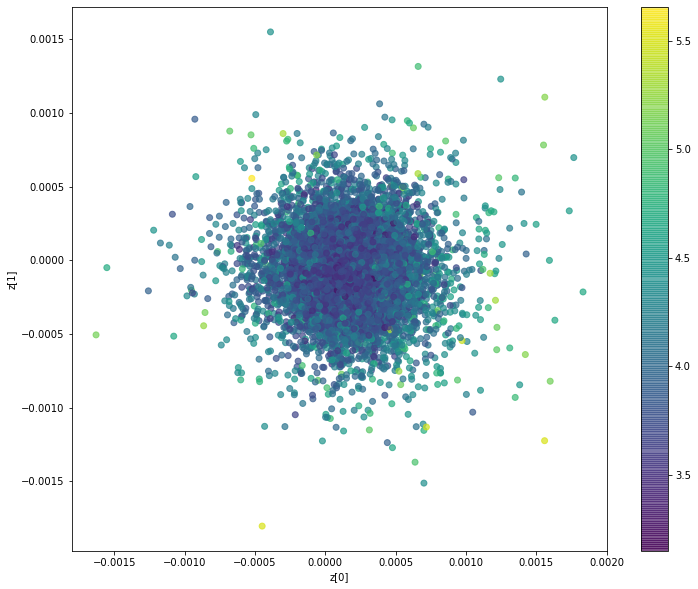

In [13]:
plt.figure(figsize=(12, 10))
plt.scatter(mu_stack[:, 1].cpu().detach().numpy(), mu_stack[:, 2].cpu().detach().numpy(), c=pred_stack.cpu().detach().numpy(), alpha=0.7)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.colorbar()
#plt.xlim(-0.0025, 0.003)
#plt.ylim(-0.0025, 0.0025)
plt.show()

In [14]:
x = mu_stack.cpu().detach().numpy()
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

In [15]:
principalDf

,pc1,pc2
0,0.066426,0.148844
1,-0.476040,0.690738
2,1.228836,1.052093
3,0.165749,-1.235816
4,0.111061,0.098301
...,...,...
100027,0.123737,0.059560
100028,-0.077224,0.148901
100029,0.410634,-0.077334
100030,0.175211,0.097949


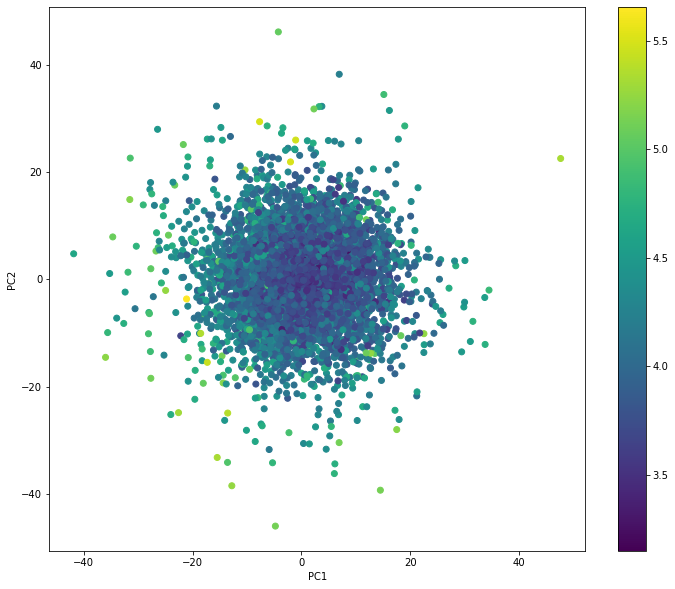

In [16]:
plt.figure(figsize=(12, 10))
plt.scatter(principalDf['pc1'].to_numpy(), 
            principalDf['pc2'].to_numpy(), 
            c=pred_stack.cpu().detach().numpy())
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar()
#plt.xlim(-0.08, -0.075)
#plt.ylim(-0.055, -0.05)
plt.show()

# Predict property with MLP

In [17]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(100, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [18]:
data = dataset.data.iloc[data_sample_index]

In [19]:
labels = torch.tensor(data.logP.values)

In [25]:
mu_stack.size()

torch.Size([100032, 100])

In [20]:
data

,smiles,fragments,n_fragments,C,F,N,O,Other,SINGLE,DOUBLE,TRIPLE,Tri,Quad,Pent,Hex,logP,mr,qed,SAS
43127,COc1cc(C=NNC(=O)CNc2cccc(Cl)c2)nc(OC)n1,*CC(=O)NN=Cc1cc(OC)nc(OC)n1 *Nc1cccc(Cl)c1,2,15,0,5,3,1,17,8,0,0,0,0,2,1.70940,90.8144,0.583055,2.526621
8609,COC(=O)c1ccccc1-c1cc(C)cc2c1OC(CNC(=O)c1cc(C)o...,*C(=O)OC *c1ccccc1-c1cc(C)cc2c1OC(CNC(=O)c1cc(...,2,23,0,2,5,0,23,10,0,0,0,2,2,3.47854,109.6477,0.652642,2.947322
42329,O=C(O)c1cc(NC(=O)c2ccc3c(c2)C(=O)N(CC2CCCO2)C3...,*C(=O)O *C(=O)Nc1cc(*)cc(C(=O)O)c1 *c1ccc2c(c1...,4,22,0,2,8,0,24,11,0,0,0,2,2,2.11030,109.0968,0.580447,2.750334
75313,CCN(CC)S(=O)(=O)c1ccc(O)c(NS(=O)(=O)c2ccccc2F)c1,*N(CC)CC *S(=O)(=O)c1ccc(O)c(NS(=O)(=O)c2ccccc...,2,16,1,2,5,2,17,10,0,0,0,0,2,2.36260,95.4221,0.692184,2.163171
19677,CC1=C(c2ccc(C(C)C)cc2)S(=O)(=O)N=C1NCc1ccc(OC(...,*c1ccc(C2=C(C)C(NCc3ccc(OC(C)C)cc3)=NS2(=O)=O)...,2,23,0,2,3,1,21,10,0,0,0,1,2,4.85990,118.5255,0.735667,2.487753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39894,CCCC(=O)N1c2ccccc2C(=C2SC(C(=O)OC)=C(C(=O)OC)S...,*C(=O)CCC *N1c2ccccc2C(=C2SC(C(=O)OC)=C(C(=O)O...,2,22,0,1,5,3,24,9,0,0,0,1,2,4.68800,128.6730,0.351407,3.056327
87286,Cc1cn(C2OC(CO[Si](C)(C)C(C)(C)C)C3(OS(=O)(=O)C...,*n1cc(C)c(=O)n(C)c1=O *C1OC(CO[Si](*)(C)C)C2(O...,3,28,0,3,11,3,39,8,0,0,0,2,1,2.34852,171.2733,0.208264,5.391074
84288,O=C(C1=C(O)C(=O)N(CCCN2CCOCC2)C1c1ccc(Cl)cc1)c...,*N1C(=O)C(O)=C(C(=O)c2ccc3c(c2)OCCO3)C1c1ccc(C...,2,26,0,2,6,1,30,9,0,0,0,1,4,3.41180,129.1993,0.585067,2.944676
30112,CNC(C)C(=O)NC(C(=O)NC(C(=O)NNc1ccccc1)C(C)C)C(C)C,*C(=O)C(C)NC *NNC(=O)C(NC(=O)C(N*)C(C)C)C(C)C ...,3,20,0,5,3,0,22,6,0,0,0,0,1,1.01920,110.2665,0.382505,3.105852


In [26]:
MLP_model = MLP()

In [27]:
optimizer = torch.optim.Adam(MLP_model.parameters(), lr=0.001)
#loss_fn = F.mse_loss()
latent_output_data = mu_stack

In [28]:
latent_output_data

tensor([[ 4.1693e-05,  1.5844e-04, -8.9221e-05,  ...,  7.1637e-06,
         -8.9668e-06, -1.6731e-04],
        [-2.8014e-05,  2.1209e-04, -1.1460e-04,  ..., -1.3661e-05,
          1.0181e-05, -1.6242e-04],
        [ 2.1309e-05,  1.7310e-04, -1.2962e-04,  ...,  8.4825e-06,
         -1.7386e-05, -1.2944e-04],
        ...,
        [ 1.6287e-05,  1.2852e-04, -7.5199e-05,  ..., -9.5405e-06,
          6.5155e-06, -1.8413e-04],
        [ 3.1352e-05,  1.1821e-04, -1.1038e-04,  ...,  1.3970e-06,
          1.1958e-06, -1.9484e-04],
        [ 5.2750e-05,  1.1416e-04, -7.6853e-05,  ...,  6.2026e-06,
         -1.5717e-05, -1.7324e-04]], device='cuda:0', grad_fn=<CatBackward0>)

In [29]:
mean_train_losses = []
mean_valid_losses = []
valid_acc_list = []
epochs = 20

for epoch in range(epochs):
    MLP_model.train()
    
    train_losses = []
    valid_losses = [] 
    output_final = []
    for i, (latent_data) in enumerate(latent_output_data):
        
        outputs = MLP_model(Variable(latent_data.cpu()))
        if epoch + 1 == epochs:
            output_final.append(outputs.item())
        loss = F.mse_loss(outputs.type(torch.float64), labels[i])
        #print(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
            
    model.eval()
    mean_train_losses.append(np.mean(train_losses))
    print('epoch : {}, train loss : {:.4f}'\
         .format(epoch+1, np.mean(train_losses)))

<ipython-input-29-551a13c8de1b>:17: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(outputs.type(torch.float64), labels[i])


epoch : 1, train loss : 3.3177
epoch : 2, train loss : 3.2980
epoch : 3, train loss : 3.2884
epoch : 4, train loss : 3.2831
epoch : 5, train loss : 3.2809
epoch : 6, train loss : 3.2805
epoch : 7, train loss : 3.2802
epoch : 8, train loss : 3.2800
epoch : 9, train loss : 3.2798
epoch : 10, train loss : 3.2795
epoch : 11, train loss : 3.2793
epoch : 12, train loss : 3.2792
epoch : 13, train loss : 3.2791
epoch : 14, train loss : 3.2790
epoch : 15, train loss : 3.2788
epoch : 16, train loss : 3.2787
epoch : 17, train loss : 3.2786
epoch : 18, train loss : 3.2784
epoch : 19, train loss : 3.2781
epoch : 20, train loss : 3.2778


In [43]:
latent_data.size()

torch.Size([100])

In [32]:
labels[i]

tensor(0.9203, dtype=torch.float64)

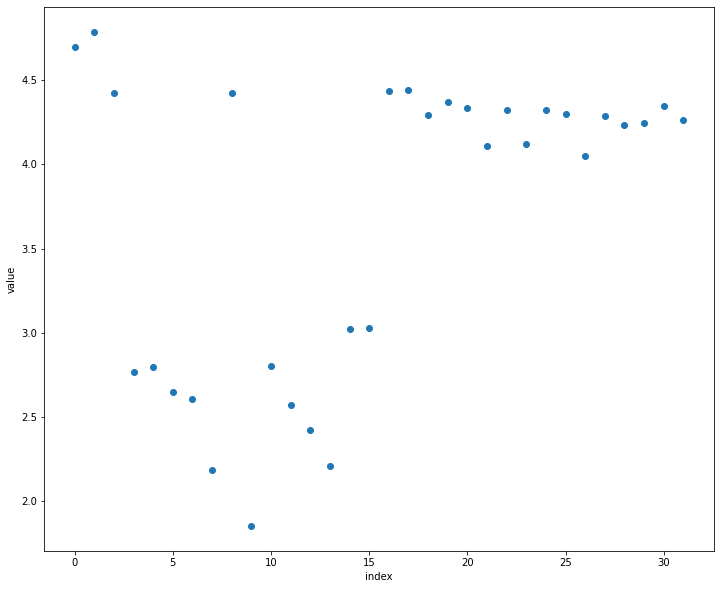

In [31]:
plt.figure(figsize=(12, 10))
plt.scatter( np.arange(len(output_final)),np.array(output_final))
#plt.scatter( np.arange(len(labels.detach().numpy())),np.array(labels.detach().numpy()))
plt.xlabel("index")
plt.ylabel("value")
#plt.xlim(100,200)
plt.show()

# Plot Net

In [62]:
outputs, mu, sigma, z, pred = model(src, lengths)

In [63]:
from torchviz import make_dot

make_dot(outputs, params=dict(list(model.named_parameters()))).render("frag_20_torchviz", format="png")

'frag_20_torchviz.png'

# Plot Embedding Space

In [6]:
vocab.w2i

{'<PAD>': 0,
 '<SOS>': 1,
 '<EOS>': 2,
 'cluster_4': 3,
 'cluster_5': 4,
 'cluster_3': 5,
 'cluster_6': 6,
 'cluster_2': 7,
 'cluster_7': 8,
 '*OCC': 9,
 'cluster_1': 10,
 '*c1ccccc1': 11,
 '*c1ccc(OC)cc1': 12,
 '*C(C)=O': 13,
 '*C(C)C': 14,
 '*CCC': 15,
 '*N(C)C': 16,
 '*c1ccc(C)cc1': 17,
 '*C(=O)O': 18,
 '*C(=O)OC': 19,
 '*CCCC': 20,
 'cluster_0': 21,
 '*C(C)(C)C': 22,
 '*c1ccccc1OC': 23,
 '*Cc1ccccc1': 24,
 '*c1cccc(OC)c1': 25,
 '*N(CC)CC': 26,
 '*c1ccc(OC)c(OC)c1': 27,
 '*C(F)(F)F': 28,
 'cluster_m1': 29,
 '*C(N)=O': 30,
 '*CC=C': 31,
 '*c1ccccc1C': 32,
 '*CCOC': 33,
 '*c1cccc(C)c1': 34,
 '*c1ccc(Cl)cc1': 35,
 '*CC(C)C': 36,
 '*c1ccc(F)cc1': 37,
 '*CC(=O)O': 38,
 '*CCN*': 39,
 '*N1CCN(C)CC1': 40,
 '*c1cc(OC)c(OC)c(OC)c1': 41,
 '*NCC': 42,
 '*NC(*)=O': 43,
 '*S(C)(=O)=O': 44,
 '*C(=O)NC': 45,
 '*N1CCOCC1': 46,
 '*CCCCC': 47,
 '*C(=O)CC': 48,
 'cluster_m2': 49,
 '*C(=O)c1ccccc1': 50,
 '*=C(C)C': 51,
 '*S(=O)(=O)c1ccc(C)cc1': 52,
 '*CCCCCC': 53,
 '*Nc1ccccc1': 54,
 '*c1ccco1': 55,
 '*

In [7]:
df_vocab_i2w = pd.DataFrame.from_dict(vocab.i2w, orient='index')
df_vocab_i2w = df_vocab_i2w.rename(columns = {0: 'fragment'}) 
df_vocab_i2w['sum_log_p'] = 0
df_vocab_i2w['count_log_p'] = 0

In [8]:
vocab.w2w_infreq

{'*N(CCc1cccc(-c2ccccc2)c1)C(=O)C1OC(C(=O)O)=CC(N)C1NC(C)=O': 'cluster_3',
 '*C1CC(c2ccccc2)=NN1C(=S)Nc1ccccc1': 'cluster_5',
 '*CCCC=C(c1cc(*)c(OC)c(Cl)c1)c1cc(Cl)c(OC)c(C(=O)OC)c1': 'cluster_7',
 '*COc1ccc(NC(=O)C2CN(C)CCC2C(=O)NO)cc1': 'cluster_4',
 '*C(=O)c1ccc(O)c(-n2cc3c(c2-c2ccccc2)c(=O)n(C)c(=O)n3C)c1': 'cluster_3',
 '*c1cccc(-c2ccc(C#N)cc2)c1': 'cluster_6',
 '*CC1(OC)OOC(*)(C)CC1CO': 'cluster_4',
 '*Nc1ccc2c3c(cccc13)C(=O)N(CCCN1CCCNCCNCCCNCC1)C2=O': 'cluster_5',
 '*N1C2CCC1C(C(=O)OC)=C(c1cc3ccccc3o1)C2': 'cluster_5',
 '*=Cc1cccc(C(F)(F)P(=O)(O)O)c1': 'cluster_4',
 '*c1cc(N)nc(NC2CCCC2)c1': 'cluster_3',
 '*N(CC)c1ccc(OC)c2nc(NC(=O)C3CCN(C(=O)c4cccc(C(F)(F)F)c4)CC3)sc12': 'cluster_6',
 '*C1CCC(C)C(c2ccc(C)cc2)N1C(=O)c1ccc(C=NOCC(O)COCc2ccco2)cc1': 'cluster_5',
 '*C(=O)C1(Cc2ccccc2C)CCCN(C(=O)CCC(=O)OC)C1': 'cluster_3',
 '*n1c(CN2C(=O)COc3c2cc(C)cc3[N+](=O)[O-])nnc1-c1ccc(Cl)cn1': 'cluster_4',
 '*NC(=O)c1cc(-c2cccc(F)c2)ccn1': 'cluster_4',
 '*c1cccnc1C1CC(O)C(NC(=N)N)CC1NC(=N)N'

In [9]:
df_vocab_w2w_infreq = pd.DataFrame.from_dict(vocab.w2w_infreq, orient='index').reset_index()
df_vocab_w2w_infreq = df_vocab_w2w_infreq.rename(columns = {'index': 'fragment', 0: 'cluster'}) 

In [10]:
fragment_statistics = []

In [11]:
for i in tqdm(range(len(dataset.data))):
    fragments = dataset.data.fragments[i]
    fragment_log_p = dataset.data.logP[i]
    frag_list = fragments.split()
    for frag in frag_list:
        fragment_statistics.append([frag, fragment_log_p])

100%|██████████| 103491/103491 [00:02<00:00, 49761.33it/s]


In [12]:
df_fragment_statistics = pd.DataFrame(fragment_statistics, columns=["Fragment", "LogP"])

In [13]:
vocab.w2w_infreq["*N(CCc1cccc(-c2ccccc2)c1)C(=O)C1OC(C(=O)O)=CC(N)C1NC(C)=O"]

'cluster_3'

In [14]:
for infreq_frag in tqdm(vocab.w2w_infreq):
    df_fragment_statistics.loc[df_fragment_statistics['Fragment'] == infreq_frag, "cluster"] = vocab.w2w_infreq[infreq_frag]

100%|██████████| 99630/99630 [22:21<00:00, 74.27it/s]


In [15]:
df_fragment_statistics

,Fragment,LogP,cluster
0,*CCC,2.33400,NaN
1,*N(CCc1cccc(-c2ccccc2)c1)C(=O)C1OC(C(=O)O)=CC(...,2.33400,cluster_3
2,*c1ccc(O)cc1,4.94030,NaN
3,*C1CC(c2ccccc2)=NN1C(=S)Nc1ccccc1,4.94030,cluster_5
4,*C(=O)OC,6.07540,NaN
...,...,...,...
231861,*CN1C(=O)NC2(CCCC2)C1=O,1.39340,NaN
231862,*C(=O)N1CCN(c2cccnn2)CC1,2.72930,cluster_3
231863,*Nc1ccc(OC(F)(F)F)cc1,2.72930,NaN
231864,*c1cc(F)ccc1C,5.59412,NaN


Mean LogP for cluster_1: 0.58


<AxesSubplot:>

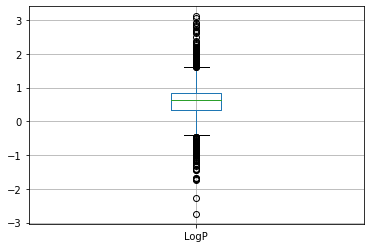

In [18]:
print("Mean LogP for cluster_1: %.2f" % np.mean(df_fragment_statistics[df_fragment_statistics['cluster']=='cluster_1'].LogP))
df_fragment_statistics[df_fragment_statistics['cluster']=='cluster_1'].boxplot(column=['LogP']) 

Mean LogP for cluster_2: 1.57


<AxesSubplot:>

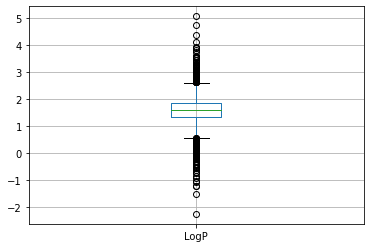

In [19]:
print("Mean LogP for cluster_2: %.2f" % np.mean(df_fragment_statistics[df_fragment_statistics['cluster']=='cluster_2'].LogP))
df_fragment_statistics[df_fragment_statistics['cluster']=='cluster_2'].boxplot(column=['LogP']) 

Mean LogP for cluster_m5: -5.42


<AxesSubplot:>

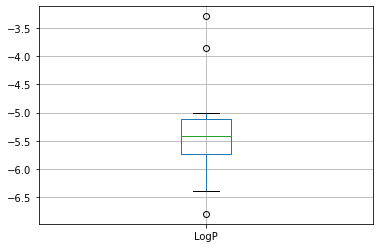

In [22]:
print("Mean LogP for cluster_m5: %.2f" % np.mean(df_fragment_statistics[df_fragment_statistics['cluster']=='cluster_m5'].LogP))
df_fragment_statistics[df_fragment_statistics['cluster']=='cluster_m5'].boxplot(column=['LogP']) 

Mean LogP for cluster 6: 5.44


<AxesSubplot:>

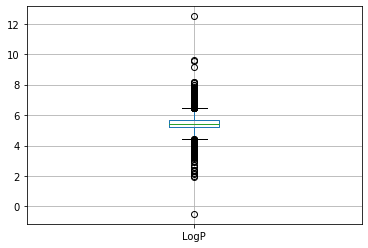

In [24]:
print("Mean LogP for cluster 6: %.2f" % np.mean(df_fragment_statistics[df_fragment_statistics['cluster']=='cluster_6'].LogP))
df_fragment_statistics[df_fragment_statistics['cluster']=='cluster_6'].boxplot(column=['LogP']) 

In [20]:
df_fragment_statistics

,Fragment,LogP,cluster
0,*CCC,2.33400,NaN
1,*N(CCc1cccc(-c2ccccc2)c1)C(=O)C1OC(C(=O)O)=CC(...,2.33400,cluster1_1
2,*c1ccc(O)cc1,4.94030,NaN
3,*C1CC(c2ccccc2)=NN1C(=S)Nc1ccccc1,4.94030,cluster1_1
4,*C(=O)OC,6.07540,NaN
...,...,...,...
231861,*CN1C(=O)NC2(CCCC2)C1=O,1.39340,NaN
231862,*C(=O)N1CCN(c2cccnn2)CC1,2.72930,cluster1_1
231863,*Nc1ccc(OC(F)(F)F)cc1,2.72930,NaN
231864,*c1cc(F)ccc1C,5.59412,NaN


In [21]:
df_fragment_statistics.groupby('Fragment').std().reset_index()['LogP']

0         0.496781
1              NaN
2              NaN
3              NaN
4              NaN
            ...   
107603    0.289631
107604    1.495876
107605    1.404381
107606    0.059185
107607         NaN
Name: LogP, Length: 107608, dtype: float64

In [22]:
df_fragment_statistics.groupby('Fragment').size().reset_index()[0]

0          5
1          1
2          1
3          1
4          1
          ..
107603     2
107604    12
107605     8
107606     2
107607     1
Name: 0, Length: 107608, dtype: int64

In [23]:
df_fragment_statistics_unique = df_fragment_statistics.groupby('Fragment').mean().reset_index()

In [24]:
df_fragment_statistics_unique['LogP_std'] = df_fragment_statistics.groupby('Fragment').std().reset_index()['LogP']
df_fragment_statistics_unique['frequency'] = df_fragment_statistics.groupby('Fragment').size().reset_index()[0]

In [25]:
df_fragment_statistics_unique

,Fragment,LogP,LogP_std,frequency
0,*#CC(C)(C)C,5.379280,0.496781,5
1,*#CC1(C(F)(F)F)CCC1,6.163200,NaN,1
2,*#CC1CCC(CNCC(F)(F)F)N1,6.430400,NaN,1
3,*#CC=CC(O)COc1ccc(F)cc1,1.060400,NaN,1
4,*#CCCCC#CCS(=O)(=O)c1ccc2ccccc2c1,6.954000,NaN,1
...,...,...,...,...
107603,*n1sc2cc(F)ccc2c1=O,3.045600,0.289631,2
107604,*n1sc2ccccc2c1=O,3.773668,1.495876,12
107605,*n1sc2nc(C)cc(C)c2c1=O,2.258250,1.404381,8
107606,*n1sc2ncccc2c1=O,2.506250,0.059185,2


In [26]:
df_fragment_statistics_unique_infreq = df_fragment_statistics_unique[df_fragment_statistics_unique['frequency']<=2].reset_index(drop = True)

array([[<AxesSubplot:title={'center':'LogP'}>,
        <AxesSubplot:title={'center':'LogP_std'}>],
       [<AxesSubplot:title={'center':'frequency'}>, <AxesSubplot:>]],
      dtype=object)

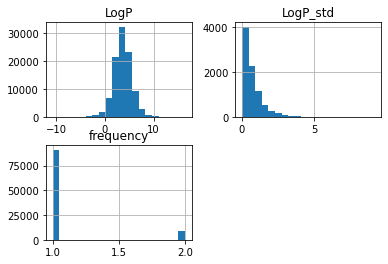

In [27]:
df_fragment_statistics_unique_infreq.hist(bins = 20)

In [28]:
len(df_fragment_statistics_unique_infreq[(df_fragment_statistics_unique_infreq['LogP']>=9) & (df_fragment_statistics_unique_infreq['LogP']<10)])

329

In [36]:
df_fragment_statistics_unique_infreq['cluster'] = ''

In [37]:
df_fragment_statistics_unique_infreq

,Fragment,LogP,LogP_std,frequency,cluster
0,*#CC1(C(F)(F)F)CCC1,6.16320,NaN,1,
1,*#CC1CCC(CNCC(F)(F)F)N1,6.43040,NaN,1,
2,*#CC=CC(O)COc1ccc(F)cc1,1.06040,NaN,1,
3,*#CCCCC#CCS(=O)(=O)c1ccc2ccccc2c1,6.95400,NaN,1,
4,*#CCCCCC#CCS(=O)(=O)c1ccc2ccccc2c1,5.81310,NaN,1,
...,...,...,...,...,...
99625,*n1sc(=O)n(Cc2ccccc2)c1=O,1.52225,0.010677,2,
99626,*n1sc(N)c(C(=O)OCC)c1=S,2.22399,NaN,1,
99627,*n1sc2cc(F)ccc2c1=O,3.04560,0.289631,2,
99628,*n1sc2ncccc2c1=O,2.50625,0.059185,2,


In [38]:
df_fragment_statistics_unique_infreq.loc[(df_fragment_statistics_unique_infreq['LogP'] < -6), 'cluster'] = 'cluster_m6'
df_fragment_statistics_unique_infreq.loc[(df_fragment_statistics_unique_infreq['LogP'] >= -6) 
                                         & (df_fragment_statistics_unique_infreq['LogP'] < -5), 'cluster'] = 'cluster_m5'
df_fragment_statistics_unique_infreq.loc[(df_fragment_statistics_unique_infreq['LogP'] >= -5) 
                                         & (df_fragment_statistics_unique_infreq['LogP'] < -4), 'cluster'] = 'cluster_m4'
df_fragment_statistics_unique_infreq.loc[(df_fragment_statistics_unique_infreq['LogP'] >= -4) 
                                         & (df_fragment_statistics_unique_infreq['LogP'] < -3), 'cluster'] = 'cluster_m3'
df_fragment_statistics_unique_infreq.loc[(df_fragment_statistics_unique_infreq['LogP'] >= -3) 
                                         & (df_fragment_statistics_unique_infreq['LogP'] < -2), 'cluster'] = 'cluster_m2'
df_fragment_statistics_unique_infreq.loc[(df_fragment_statistics_unique_infreq['LogP'] >= -2) 
                                         & (df_fragment_statistics_unique_infreq['LogP'] < -1), 'cluster'] = 'cluster_m1'
df_fragment_statistics_unique_infreq.loc[(df_fragment_statistics_unique_infreq['LogP'] >= -1) 
                                         & (df_fragment_statistics_unique_infreq['LogP'] < 0), 'cluster'] = 'cluster_0'
df_fragment_statistics_unique_infreq.loc[(df_fragment_statistics_unique_infreq['LogP'] >= 0) 
                                         & (df_fragment_statistics_unique_infreq['LogP'] < 1), 'cluster'] = 'cluster_1'
df_fragment_statistics_unique_infreq.loc[(df_fragment_statistics_unique_infreq['LogP'] >= 1) 
                                         & (df_fragment_statistics_unique_infreq['LogP'] < 2), 'cluster'] = 'cluster_2'
df_fragment_statistics_unique_infreq.loc[(df_fragment_statistics_unique_infreq['LogP'] >= 2) 
                                         & (df_fragment_statistics_unique_infreq['LogP'] < 3), 'cluster'] = 'cluster_3'
df_fragment_statistics_unique_infreq.loc[(df_fragment_statistics_unique_infreq['LogP'] >= 3) 
                                         & (df_fragment_statistics_unique_infreq['LogP'] < 4), 'cluster'] = 'cluster_4'
df_fragment_statistics_unique_infreq.loc[(df_fragment_statistics_unique_infreq['LogP'] >= 4) 
                                         & (df_fragment_statistics_unique_infreq['LogP'] < 5), 'cluster'] = 'cluster_5'
df_fragment_statistics_unique_infreq.loc[(df_fragment_statistics_unique_infreq['LogP'] >= 5) 
                                         & (df_fragment_statistics_unique_infreq['LogP'] < 6), 'cluster'] = 'cluster_6'
df_fragment_statistics_unique_infreq.loc[df_fragment_statistics_unique_infreq['LogP'] >= 6, 'cluster'] = 'cluster_7'

In [59]:
df_fragment_statistics_unique_infreq

,Fragment,LogP,LogP_std,frequency,cluster
0,*#CC1(C(F)(F)F)CCC1,6.16320,NaN,1,cluster_7
1,*#CC1CCC(CNCC(F)(F)F)N1,6.43040,NaN,1,cluster_7
2,*#CC=CC(O)COc1ccc(F)cc1,1.06040,NaN,1,cluster_2
3,*#CCCCC#CCS(=O)(=O)c1ccc2ccccc2c1,6.95400,NaN,1,cluster_7
4,*#CCCCCC#CCS(=O)(=O)c1ccc2ccccc2c1,5.81310,NaN,1,cluster_6
...,...,...,...,...,...
99625,*n1sc(=O)n(Cc2ccccc2)c1=O,1.52225,0.010677,2,cluster_2
99626,*n1sc(N)c(C(=O)OCC)c1=S,2.22399,NaN,1,cluster_3
99627,*n1sc2cc(F)ccc2c1=O,3.04560,0.289631,2,cluster_4
99628,*n1sc2ncccc2c1=O,2.50625,0.059185,2,cluster_3


In [61]:
df_fragment_statistics_unique_infreq.loc[df_fragment_statistics_unique_infreq['Fragment'] == '*#CC1(C(F)(F)F)CCC1', 'cluster'][0]

'cluster_7'

In [45]:
df_fragment_statistics_unique_cluster = pd.concat([df_fragment_statistics_unique[df_fragment_statistics_unique['frequency'] > 2], df_fragment_statistics_unique_infreq])

In [46]:
df_fragment_statistics

,Fragment,LogP,cluster
0,*CCC,2.33400,NaN
1,*N(CCc1cccc(-c2ccccc2)c1)C(=O)C1OC(C(=O)O)=CC(...,2.33400,cluster1_1
2,*c1ccc(O)cc1,4.94030,NaN
3,*C1CC(c2ccccc2)=NN1C(=S)Nc1ccccc1,4.94030,cluster1_1
4,*C(=O)OC,6.07540,NaN
...,...,...,...
231861,*CN1C(=O)NC2(CCCC2)C1=O,1.39340,NaN
231862,*C(=O)N1CCN(c2cccnn2)CC1,2.72930,cluster1_1
231863,*Nc1ccc(OC(F)(F)F)cc1,2.72930,NaN
231864,*c1cc(F)ccc1C,5.59412,NaN


In [53]:
def calculate_frequencies(sentences):
    w2f = defaultdict(int)

    for sentence in sentences:
        for word in sentence:
            w2f[word] += 1

    return w2f

In [79]:
SOS_TOKEN = '<SOS>'
PAD_TOKEN = '<PAD>'
EOS_TOKEN = '<EOS>'
TOKENS = [SOS_TOKEN, PAD_TOKEN, EOS_TOKEN]
start = time.time()
print("Training and clustering embeddings...", end=" ")

embed_size = config.get('embed_size')
embed_window = config.get('embed_window')
mask_freq = config.get('mask_freq')
use_mask = config.get('use_mask')

i2w_infreq = None
w2w_infreq = None
c2w_infreq = None
start_idx = len(TOKENS)

if use_mask:
    sentences = [s.split(" ") for s in df_fragment_statistics.Fragment]
    # first word embedding
    w2v = Word2Vec(
        sentences,
        vector_size=embed_size,
        window=embed_window,
        min_count=1,
        negative=5,
        workers=20,
        epochs=10,
        sg=1)

    vocab = w2v.wv.key_to_index
    embeddings = w2v.wv[vocab]

    w2f = calculate_frequencies(sentences)
    w2i = {k: v for (k, v) in vocab.items()}
    i2w = {v: k for (k, v) in w2i.items()}

    infreq = [w2i[w] for (w, freq) in w2f.items() if freq <= mask_freq]            
    i2w_infreq = {}
    for inf in tqdm(infreq):
        word = i2w[inf]
        i2w_infreq[inf] = df_fragment_statistics_unique_infreq.loc[df_fragment_statistics_unique_infreq['Fragment'] == word, 'cluster'].values[0]
        
end = time.time() - start
elapsed = time.strftime("%H:%M:%S", time.gmtime(end))
print(f'Done. Time elapsed: {elapsed}.')

Training and clustering embeddings... 

100%|██████████| 99630/99630 [23:27<00:00, 70.79it/s]

Done. Time elapsed: 00:23:32.


In [80]:
w2w_infreq = {i2w[k]: v for (k, v) in i2w_infreq.items()}
c2w_infreq = defaultdict(list)
for word, cluster_name in w2w_infreq.items():
    c2w_infreq[cluster_name].append(word)

# substitute infrequent words with cluster words
data = []
for sentence in sentences:
    sentence_sub = []
    for word in sentence:
        if word in w2w_infreq:
            word = w2w_infreq[word]
        sentence_sub.append(word)
    data.append(sentence_sub)

In [82]:
w2i = {PAD_TOKEN: 0, SOS_TOKEN: 1, EOS_TOKEN: 2}

w2v = Word2Vec(
        data,
        vector_size=embed_size,
        window=embed_window,
        min_count=1,
        negative=5,
        workers=20,
        epochs=10,
        sg=1)

vocab = w2v.wv.key_to_index
w2i.update({k: v + start_idx for (k, v) in vocab.items()})
i2w = {v: k for (k, v) in w2i.items()}

tokens = np.random.uniform(-0.05, 0.05, size=(start_idx, embed_size))
embeddings = np.vstack([tokens, w2v.wv[vocab]])
path = config.path('config') / f'emb_{embed_size}_2.dat'
np.savetxt(path, embeddings, delimiter=",")

In [57]:
w2f

defaultdict(int,
            {'*CCC': 1949,
             '*N(CCc1cccc(-c2ccccc2)c1)C(=O)C1OC(C(=O)O)=CC(N)C1NC(C)=O': 1,
             '*c1ccc(O)cc1': 258,
             '*C1CC(c2ccccc2)=NN1C(=S)Nc1ccccc1': 1,
             '*C(=O)OC': 1550,
             '*CCCC=C(c1cc(*)c(OC)c(Cl)c1)c1cc(Cl)c(OC)c(C(=O)OC)c1': 1,
             '*C(=O)SC': 5,
             '*c1cc(C)nc2ccccc12': 58,
             '*COc1ccc(NC(=O)C2CN(C)CCC2C(=O)NO)cc1': 1,
             '*OCC': 4930,
             '*C(=O)c1ccc(O)c(-n2cc3c(c2-c2ccccc2)c(=O)n(C)c(=O)n3C)c1': 1,
             '*c1cc(=O)oc2cc(OC)cc(OC)c12': 4,
             '*c1cccc(-c2ccc(C#N)cc2)c1': 1,
             '*c1cc2c(OC)c(OC)c(OC)cc2[nH]1': 5,
             '*C(=O)Nc1ccc(F)cc1': 16,
             '*c1cc(F)cc(OC)c1': 5,
             '*C(=O)NC(CC(=O)O)c1ccc(*)cc1': 3,
             '*C1CCCN1S(=O)(=O)c1cc(Cl)cc(Cl)c1': 3,
             '*c1ccc(Cl)c(OC)c1': 9,
             '*c1cc(OC)c(-n2c(=O)ccc3cc(S(=O)(=O)Nc4cccnn4)ccc32)cc1F': 4,
             '*CCCC': 1479,
    

In [ ]:
    infreq = [w2i[w] for (w, freq) in w2f.items() if freq <= mask_freq]            
    i2w_infreq = {}
    for inf in infreq:
        word = i2w[inf]
        i2w_infreq[inf] = f"cluster{w2f[word]}_{word.count('*')}"

    w2w_infreq = {i2w[k]: v for (k, v) in i2w_infreq.items()}
    c2w_infreq = defaultdict(list)
    for word, cluster_name in w2w_infreq.items():
        c2w_infreq[cluster_name].append(word)

    # substitute infrequent words with cluster words
    data = []
    for sentence in sentences:
        sentence_sub = []
        for word in sentence:
            if word in w2w_infreq:
                word = w2w_infreq[word]
            sentence_sub.append(word)
        data.append(sentence_sub)
else:
    data = [s.split(" ") for s in data.fragments]

w2i = {PAD_TOKEN: 0, SOS_TOKEN: 1, EOS_TOKEN: 2}

w2v = Word2Vec(
        data,
        vector_size=embed_size,
        window=embed_window,
        min_count=1,
        negative=5,
        workers=20,
        epochs=10,
        sg=1)

vocab = w2v.wv.key_to_index
w2i.update({k: v + start_idx for (k, v) in vocab.items()})
i2w = {v: k for (k, v) in w2i.items()}

tokens = np.random.uniform(-0.05, 0.05, size=(start_idx, embed_size))
embeddings = np.vstack([tokens, w2v.wv[vocab]])
path = config.path('config') / f'emb_{embed_size}.dat'
np.savetxt(path, embeddings, delimiter=",")

In [88]:
df_fragment_statistics_unique_infreq.to_csv('DATA/CHEMBL/PROCESSED/df_fragment_statistics_unique_infreq.smi', index=False)